Files in test:  20000
Files in train:  80000
File: test/1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg Count: 0
File: test/1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8.jpeg Count: 1
File: test/1B1B4-4R3-2R2p2-K7-8-3b3r-2Q4P-R2k4.jpeg Count: 2
File: test/1B1BK3-7b-3Np3-4N3-2p1r2P-2r5-8-5k1b.jpeg Count: 3
File: test/1B1K3k-8-8-2r4R-2b5-8-7b-8.jpeg Count: 4
File: test/1B1K4-1bb3Bb-4P3-5R2-R7-8-8-6k1.jpeg Count: 5
File: test/1B1K4-1p5N-7p-1qp5-n1P5-8-6k1-b7.jpeg Count: 6
File: test/1B1K4-2b5-8-8-R3R2P-5k2-N3R1r1-1r2RR2.jpeg Count: 7
File: test/1B1K4-3B4-3p4-8-4k3-6p1-2B5-nq6.jpeg Count: 8
File: test/1B1K4-3N1k1P-6Q1-3r1n2-8-3p1NNN-8-3b2rR.jpeg Count: 9
File: test/1B1K4-3P4-6k1-1p6-6p1-8-7p-3B4.jpeg Count: 10
File: test/1B1K4-4n3-4P3-8-4Q1r1-3nk3-r7-4N3.jpeg Count: 11
File: test/1B1K4-6k1-2b2N2-4R3-7B-2pr4-2R1P3-n4n1n.jpeg Count: 12
File: test/1B1N1B1n-4K2k-2n5-3P4-B7-2b5-2p3N1-rN5n.jpeg Count: 13
File: test/1B1N4-3R4-n2b4-8-8-b2P4-5b2-2K1b2k.jpeg Count: 14
File: test/1B1N4-7k-1rP4N-1b6-6n1-5n2-2Q1K2P-r2B4.jpeg Cou

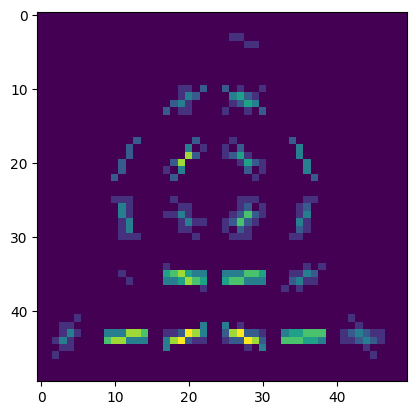

B


In [106]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage.io import imread
from skimage import color, exposure
from skimage.transform import rescale
from skimage.util import view_as_blocks

NUM_IMAGES = 100

def read_and_store_modified_chess_images():
    def fen_from_position(position, fen_string):
        rows = position // 8
        cols = position % 8
        
        # Get the character at the corresponding position in the FEN string
        character = fen_string[rows * 8 + cols]

        # If the character is a number, return that many empty squares
        if character.isdigit():
            return ' ' * int(character)
        else:
            return character

    def fen_from_filename(filename):
        # Split the filename by '/'
        parts = filename.split('/')
        # Remove File Extension
        fen_part = parts[-1].split('.')[0]

        # Replace digits with spaces
        fen_string = ''.join([' ' * int(char) if char.isdigit() else char for char in fen_part])

        # Remove dashes
        fen_string = fen_string.replace('-', '')

        return fen_string


    def HogTransform(img):
        first_image_gray = color.rgb2gray(img)

        fd, hog_image = hog(
            first_image_gray,
            orientations=8,
            pixels_per_cell=(8, 8),
            cells_per_block=(1, 1),
            visualize=True,
            block_norm='L2-Hys',
            feature_vector=True
        )

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)
        return hog_image_uint8

    def loadImages(src, fileNames, destinationPickleFile, limit):
        data = {'fenstring': [], 'data': []}

        count = 0
        for file in fileNames:
            print("File:", file, "Count:", count)
            boardPosition = 0
            if count >= limit:
                break
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                im = imread(os.path.join(src, file))
                fenString = fen_from_filename(file)
                image_height, image_width, num_channels = im.shape

                # Calculate the block shape
                block_height = image_height // 8
                block_width = image_width // 8
                patches = view_as_blocks(im, block_shape=(block_height, block_width, num_channels)).reshape(-1, block_height, block_width, num_channels)
                for patch in patches:
                    hog_features = HogTransform(patch)
                    data['data'].append(hog_features)
                    data['fenstring'].append(fen_from_position(boardPosition, fenString))
                    boardPosition += 1
            count += 1

        joblib.dump(data, destinationPickleFile)


    def load_pickle_file(file_path):
        try:
            data = joblib.load(file_path)
            return data
        except FileNotFoundError:
            print(f"Error: File '{file_path}' not found.")
            return None
        except Exception as e:
            print(f"Error loading pickle file: {e}")
            return None


    # opens the chess boards.zip file into the chessBoards object
    zipFilePath = '../chess boards.zip'
    chessBoards = ZipFile(zipFilePath, 'r')

    test = []
    train = []
    newpath = True

    # extract the file names from the train and test folders in the zip archive
    for file in chessBoards.namelist():
        # fills the file names from within the dataset subfolder
        """if file[:13] == 'dataset/test/':
            datasetTest.append(file)
        if file[:14] == 'dataset/train/':
            datasetTrain.append(file)"""

        if file[:4] == 'test':
            test.append(file)
        if file[:5] == 'train':
            train.append(file)

        # find any new file paths not accounted for
        """if file[:13] != 'dataset/test/' and \
            file[:14] != 'dataset/train/' and \
            file[:4] != 'test'and \
            file[:5] != 'train' and \
            newpath:
            print("new path: ", file)
            newpath = False"""

    print("Files in test: ", len(test))
    print("Files in train: ", len(train))

    pickle_path = 'test_data.pickle'

    loadImages(zipFilePath, test, pickle_path, NUM_IMAGES)

    # Load the pickle file and output it to a variable
    loaded_data = load_pickle_file(pickle_path)

    print(len(loaded_data['data']))
    print(len(loaded_data['fenstring']))

    first_image = loaded_data['data'][1]
    plt.imshow(first_image)
    plt.show()
    print(loaded_data['fenstring'][1])
    return loaded_data

loaded_data = read_and_store_modified_chess_images()

In [107]:
def SVM_Model():
    X = np.array(loaded_data['data'])
    y = np.array(loaded_data['fenstring'])

    # Filter out data where fenstring is not ' '
    X_filtered = [X[i] for i, fenstring in enumerate(loaded_data['fenstring']) if fenstring != ' ']
    y_filtered = [fenstring for fenstring in loaded_data['fenstring'] if fenstring != ' ']

    # Flatten each HOG image in X_filtered
    X_flat_filtered = [img.flatten() for img in X_filtered]

    # Convert to numpy array
    X_flat_filtered = np.array(X_flat_filtered)

    # Encode FEN strings into numerical labels
    label_encoder = LabelEncoder()
    y_encoded_filtered = label_encoder.fit_transform(y_filtered)

    # Split the filtered data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat_filtered, y_encoded_filtered, test_size=0.2, random_state=42)

    # Train SVM classifier
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)

    # Predict FEN string labels for the test set
    y_pred = svm_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Decode numerical labels back to original FEN strings
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_test_decoded = label_encoder.inverse_transform(y_test)

    # Print predicted and actual values for each prediction
    for pred, actual in zip(y_pred_decoded, y_test_decoded):
        print("Predicted:", pred)
        print("Actual:", actual)

SVM_Model()

Accuracy: 0.9606986899563319
Predicted: Q
Actual: Q
Predicted: R
Actual: R
Predicted: n
Actual: n
Predicted: B
Actual: B
Predicted: K
Actual: K
Predicted: P
Actual: P
Predicted: N
Actual: N
Predicted: R
Actual: R
Predicted: K
Actual: K
Predicted: p
Actual: p
Predicted: N
Actual: N
Predicted: p
Actual: p
Predicted: K
Actual: K
Predicted: p
Actual: p
Predicted: b
Actual: b
Predicted: r
Actual: r
Predicted: b
Actual: b
Predicted: R
Actual: R
Predicted: N
Actual: N
Predicted: k
Actual: k
Predicted: N
Actual: N
Predicted: K
Actual: K
Predicted: K
Actual: K
Predicted: R
Actual: R
Predicted: b
Actual: b
Predicted: k
Actual: k
Predicted: p
Actual: p
Predicted: q
Actual: q
Predicted: R
Actual: R
Predicted: P
Actual: P
Predicted: p
Actual: p
Predicted: r
Actual: r
Predicted: K
Actual: k
Predicted: k
Actual: k
Predicted: B
Actual: B
Predicted: b
Actual: b
Predicted: r
Actual: r
Predicted: B
Actual: B
Predicted: B
Actual: B
Predicted: p
Actual: k
Predicted: R
Actual: R
Predicted: N
Actual: N
Predi